### Imports

In [1]:
import os
import sys

# Configure Google Colab
def set_colab_folder(path='MyDrive/Colab Notebooks/ML4HC/project2'):
  if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive/')
    path = os.path.join('/content/drive/', path)
    sys.path.append(path)
    %cd $path

    # upgrade to solve for inconsistencies on Colab
    !pip install scikit-learn==0.22.1
    !pip install -U imbalanced-learn
    !pip install livelossplot
    !pip install glove-python-binary
    

  else:
    print('Not running on CoLab')

Uncomment and run following cell if on Colab


In [ ]:
# set_colab_folder()

In [3]:
# General
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Metrics
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, f1_score, confusion_matrix,
    plot_precision_recall_curve, plot_roc_curve, precision_recall_curve, roc_curve, auc, balanced_accuracy_score)

# Sklearn preprocessing and utility
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import CountVectorizer

# Sklearn classifier
from sklearn.linear_model import LogisticRegression

# Sampling
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline as make_pipeline_imbl

# further utility functions
from collections import Counter
import warnings
from itertools import product

# Custom helper functions
from cf_matrix import make_confusion_matrix
from utils import *
from data_io import *
from data_representation import *

# Plot settings
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [ ]:
# check scikit version on Google Colab

# if 'google.colab' in str(get_ipython()):
#   print('The scikit-learn version is {}.'.format(sklearn.__version__))

### Datasets


In [4]:
# Fix data directory
data_dir = "data"

In [ ]:
# Get dataset shapes
shapes = get_dataset_shapes()
pd.DataFrame(shapes)

,0,1
0,C_elegans_acc_seq.csv,"(2200, 2)"
1,human_dna_test_hidden_split.csv,"(30021, 1)"
2,human_dna_test_split.csv,"(33333, 2)"
3,human_dna_validation_split.csv,"(33333, 2)"
4,human_dna_train_split.csv,"(500000, 2)"
5,C_elegans_validation_split.csv,"(330, 2)"
6,C_elegans_train_split.csv,"(1540, 2)"
7,C_elegans_test_split.csv,"(330, 2)"


# C Elegans
Training and performance report on the C. Elegans dataset

### Read-in Datasets

In [ ]:
X_train, y_train = get_data(species='worm', mode='train', form='split')
X_val, y_val = get_data(species='worm', mode='val', form='split')
X_test, y_test = get_data(species='worm', mode='test', form='split')

In [6]:
# Use 0/1 labels instead of -1/1 labels
y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0

### Class Distribution

In [ ]:
print(f"Training: {Counter(y_train)}")
print(f"Validation: {Counter(y_val)}")
print(f"Test: {Counter(y_test)}")

Training: Counter({0: 1400, 1: 140})
Validation: Counter({0: 300, 1: 30})
Test: Counter({0: 300, 1: 30})


## Data preparation

In [7]:
# One-Hot encode data
X_train = one_hot_encoding(X_train)
X_val = one_hot_encoding(X_val)
X_test = one_hot_encoding(X_test)

In [8]:
# Work with dense data matrices
X_train = np.asarray(X_train.todense())
X_val = np.asarray(X_val.todense())
X_test = np.asarray(X_test.todense())

## Training

### Default

In [ ]:
# Uncomment following line and run to ignore Deprecation Warnings
# warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

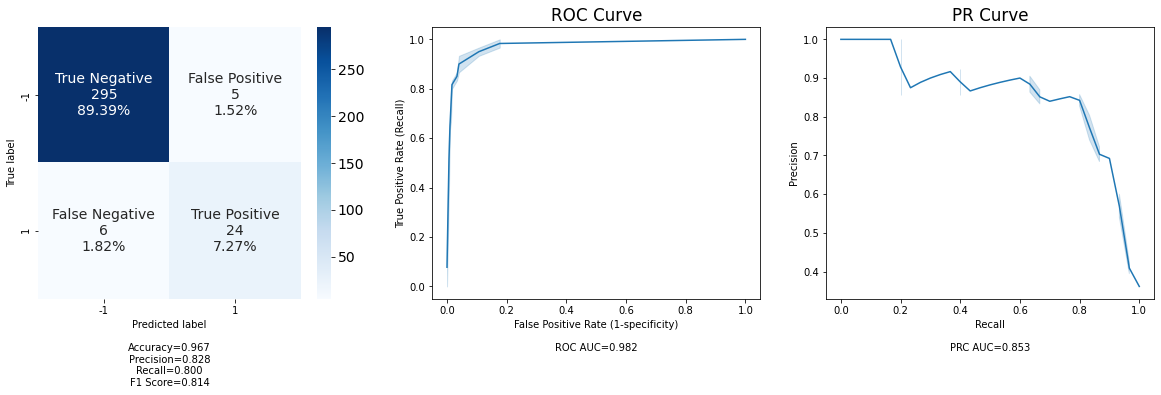

In [ ]:
y_proba, y_pred, res = pred_results(clf, X=X_test, y=y_test, model_name = 'default', figsize=(20,5))

### Class weights

In [10]:
cls_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train),  y=y_train)
cls_weight_dict = {0: cls_weights[0], 1: cls_weights[1]}

In [ ]:
clf_cls = LogisticRegression(random_state=42, max_iter=500, class_weight=cls_weight_dict)
clf_cls.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.55, 1: 5.5}, max_iter=500,
                   random_state=42)

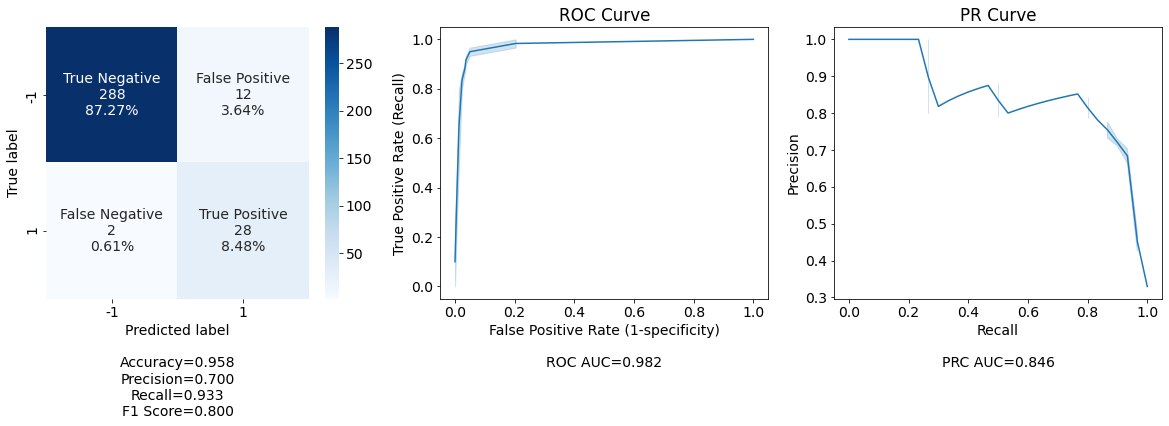

In [ ]:
_, _, res_cls = pred_results(clf=clf_cls, X=X_test, y=y_test, model_name="class_weights", figsize=(20,5))

### Over-/Undersample

##### Oversampling

In [ ]:
smote = SMOTE()  
X_os, y_os = smote.fit_resample(X_train, y_train)

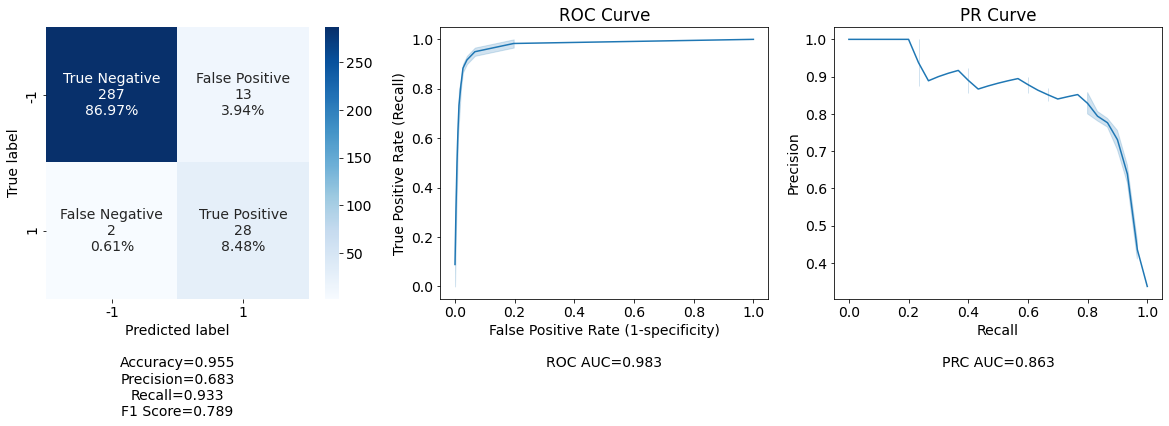

In [ ]:
clf_os = LogisticRegression(random_state=42, max_iter=500)
clf_os.fit(X_os, y_os)
_, _, res_os = pred_results(clf=clf_os, X=X_test, y=y_test, model_name="oversampling", figsize=(20,5))

##### Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_train, y_train)

print("{:.0%} of dataset kept.".format(len(y_us)/len(y_train)))

18% of dataset kept.


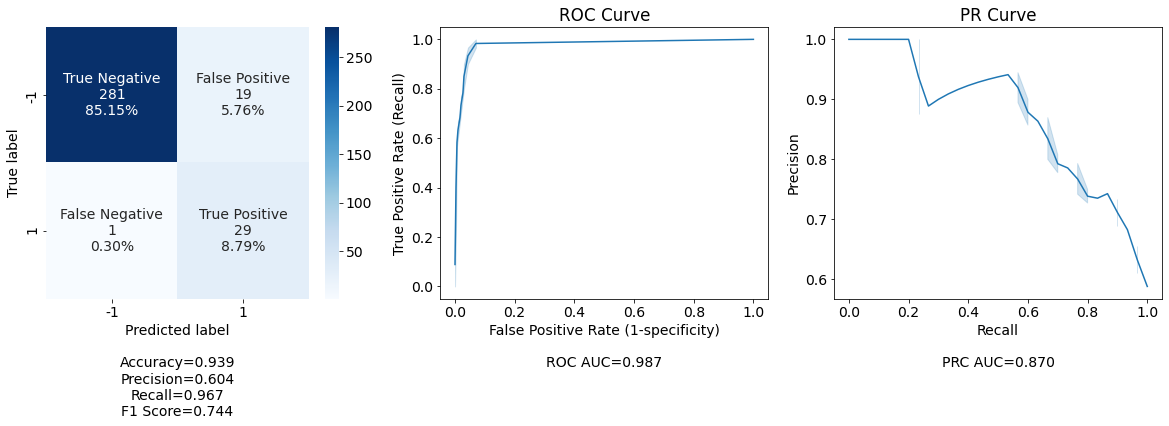

In [ ]:
clf_us = LogisticRegression(random_state=42, max_iter=500)
clf_us.fit(X_us, y_us)
_, _, res_us = pred_results(clf=clf_us, X=X_test, y=y_test, model_name="undersampling", figsize=(20,5))

##### Over- & Undersampling combinded

In [ ]:
smote_tomek = SMOTETomek(random_state=42)   
X_ous_1, y_ous_1  = smote_tomek.fit_resample(X_train, y_train)

print('Count before: {}'.format(Counter(y_train)))
print("Lenght of over-undersampled dataset is {:.0%} of the initial one.".format(len(y_ous_1)/len(y_train)))
print('Count after over-undersampling: {}'.format(Counter(y_ous_1)))

Count before: Counter({0: 1400, 1: 140})
Lenght of over-undersampled dataset is 182% of the initial one.
Count after over-undersampling: Counter({0: 1400, 1: 1400})


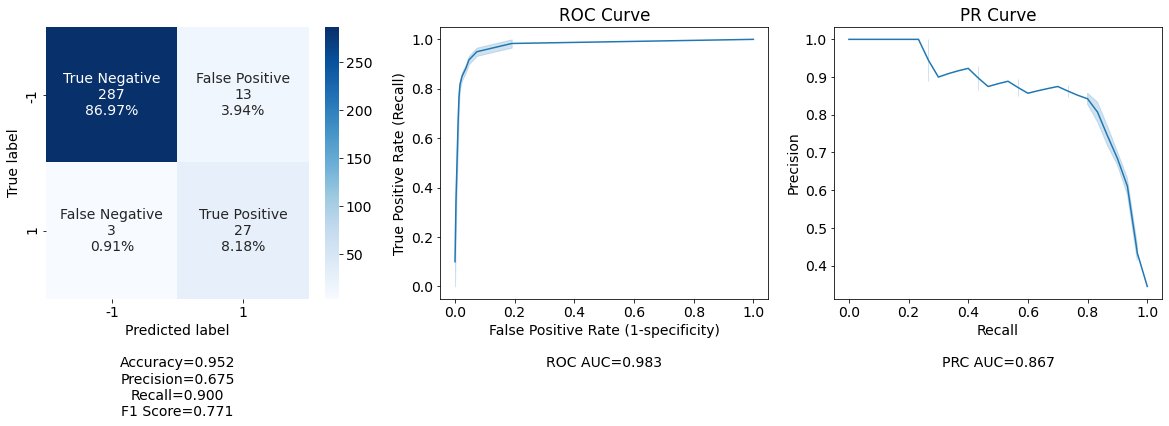

In [ ]:
clf_ous_1 = LogisticRegression(random_state=42, max_iter=500)
clf_ous_1.fit(X_ous_1, y_ous_1)
_, _, res_ous_1 = pred_results(clf=clf_ous_1, X=X_test, y=y_test, model_name="overundersampling_1", figsize=(20,5))

In [ ]:
count_class_0 = 800
count_class_1 = 800

os_pipe = make_pipeline_imbl(
    SMOTE(sampling_strategy={1: count_class_0}),
    NearMiss(sampling_strategy={0: count_class_1})
    )
X_ous_2, y_ous_2  = os_pipe.fit_resample(X_train, y_train)

print('Count before: {}'.format(Counter(y_train)))
print("Lenght of over-undersampled dataset is {:.0%} of the initial one.".format(len(y_ous_2)/len(y_train)))
print('Count after over-undersampling: {}'.format(Counter(y_ous_2)))

Count before: Counter({0: 1400, 1: 140})
Lenght of over-undersampled dataset is 104% of the initial one.
Count after over-undersampling: Counter({0: 800, 1: 800})


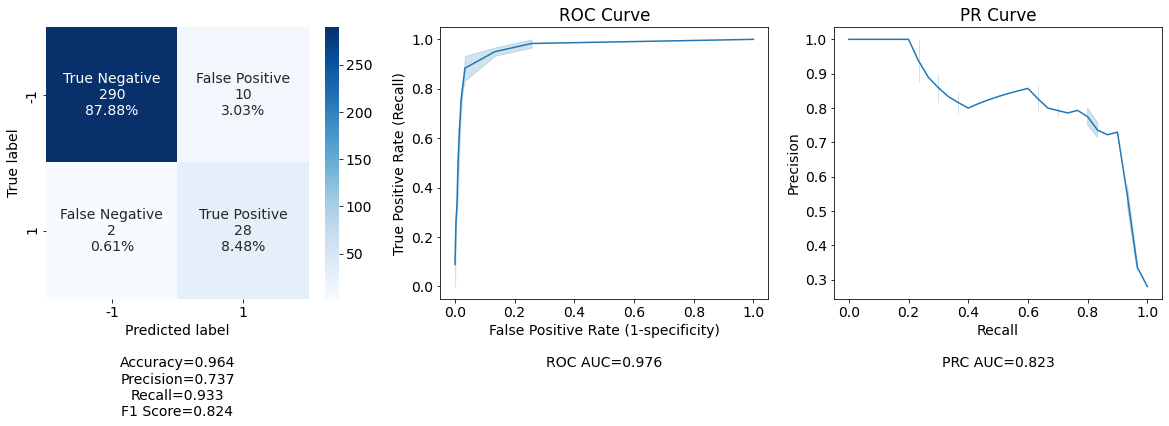

In [ ]:
clf_ous_2 = LogisticRegression(random_state=42, max_iter=500)
clf_ous_2.fit(X_ous_2, y_ous_2)
_, _, res_ous_2 = pred_results(clf=clf_ous_2, X=X_test, y=y_test, model_name="overundersampling_2", figsize=(20,5))

### Intermediate Results
We check obtained results for further analysis and tuning

In [ ]:
 results = pd.concat([res, res_cls, res_os, res_us, res_ous_1, res_ous_2], axis=0).reset_index(drop=True)
 display(results.style.highlight_max(color = 'lightgreen', axis = 0))

,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,default,0.966667,0.891667,0.981889,0.852664
1,class_weights,0.957576,0.946667,0.982111,0.845656
2,oversampling,0.954545,0.945000,0.983222,0.862768
3,undersampling,0.939394,0.951667,0.987000,0.869997
4,overundersampling_1,0.951515,0.928333,0.983111,0.866931
5,overundersampling_2,0.963636,0.950000,0.976333,0.822562


With the exception of the 2nd over-undersampling approach, results (in terms of AUC) are comparable. We will continue with class-weight approach.



### Hyperparameter tuning
We first tune for penalty mode and and regularization parameter

In [ ]:
reg_C = np.logspace(-4,4,9)   # default  C=1.0
penalty_ls = ['l2', 'l1', 'elasticnet', 'none']
hyperparam_res = pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})

for pen, c in product(penalty_ls, reg_C):
  print('Currently at penalty: {} with C: {}'.format(pen, c))

  if pen == 'elasticnet': clf = LogisticRegression(penalty=pen, C=c, solver='saga', l1_ratio=0.5, random_state=42, max_iter=2000, class_weight=cls_weight_dict)
  elif pen =='l1': clf = LogisticRegression(penalty=pen, C=c, solver='liblinear', random_state=42, max_iter=500, class_weight=cls_weight_dict)
  elif pen =='l2': clf = LogisticRegression(penalty=pen, C=c, solver='lbfgs', random_state=42, max_iter=500, class_weight=cls_weight_dict)
  else:  clf = LogisticRegression(penalty=pen, solver='lbfgs', random_state=42, max_iter=500, class_weight=cls_weight_dict)

  clf.fit(X_train, y_train)
  _, _, res= pred_results(clf=clf, X=X_val, y=y_val, model_name="class_weights_C_{}_{}".format(c,pen), figsize=None)
  hyperparam_res = pd.concat([hyperparam_res,res], axis=0).reset_index(drop=True)

We consider the (weighted) average of the four metrics considered (F1-score, balanced accuracy, PRC AUC, ROC AUC).

In [ ]:
hyperparam_res['avg'] = hyperparam_res.mean(axis=1)
hyperparam_res['weighted'] = 0.15*hyperparam_res['f1-score'] + 0.15*hyperparam_res['balanced_accuracy'] + 0.35*hyperparam_res['roc_auc'] + 0.35*hyperparam_res['prc_auc'] 

We sort for the parametrizations with highest PRC AUC and afterwards find for each metric the best parametrization.

In [ ]:
hyperparam_res.sort_values('prc_auc', ascending=False).iloc[:10,:]

In [ ]:
display(hyperparam_res.style.highlight_max(color = 'lightgreen', axis = 0))

Based on this, we will use $l_1$, $l_2$ and elastic net penalty with $C=10^{-4},10^{-3},10^{-2},10^{-1}, 1$ for the subsequent feature selection runs using kSelectBest.


In [ ]:
# warnings.filterwarnings('ignore')

reg_C = np.logspace(-4,0,5)   # default  C=1.0
penalty_ls = ['l2', 'l1', 'elasticnet']
k_select = range(25,275,25)
scoring_crit = [f_classif, chi2]

k_best_res = pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})


for k, scoring in product(k_select, scoring_crit):

  if k >= X_train.shape[1]:
    k = X_train.shape[1]
    X_k_train = X_train
    X_k_val = X_val
  else:
    selKBest = SelectKBest(score_func=scoring, k=k)
    selKBest.fit(X_train, y_train)
    X_k_train = selKBest.transform(X_train)
    X_k_val = selKBest.transform(X_val)

  for pen, c in product(penalty_ls, reg_C):

      print('Currently at scoring: {}, penalty: {}, with C: {}, and {}-best features'.format(scoring.__name__, pen, c, k))

      if pen == 'elasticnet': clf_k = LogisticRegression(penalty=pen, C=c, solver='saga', l1_ratio=0.5, random_state=42, max_iter=2000, class_weight=cls_weight_dict)
      elif pen =='l1': clf_k = LogisticRegression(penalty=pen, C=c, solver='liblinear', random_state=42, max_iter=500, class_weight=cls_weight_dict)
      elif pen =='l2': clf_k = LogisticRegression(penalty=pen, C=c, solver='lbfgs', random_state=42, max_iter=500, class_weight=cls_weight_dict)

      clf_k.fit(X_k_train, y_train)
      _, _, res_k = pred_results(clf=clf_k, X=X_k_val, y=y_val, model_name="pen-{}_c{}_score-{}_k-{}".format(pen, c, scoring.__name__, k), figsize=None)

      k_best_res = pd.concat([k_best_res,res_k], axis=0).reset_index(drop=True)

In [ ]:
k_best_res['avg'] = k_best_res.mean(axis=1)
k_best_res['weighted'] = 0.15*k_best_res['f1-score'] + 0.15*k_best_res['balanced_accuracy'] + 0.35*k_best_res['roc_auc'] + 0.35*k_best_res['prc_auc'] 

Sort for the best performing models

In [ ]:
k_best_res.sort_values('weighted', ascending=False)[:10]

In [ ]:
k_best_res.sort_values('prc_auc', ascending=False)[:10]

In [ ]:
display(k_best_res.style.highlight_max(color = 'lightgreen', axis = 0))

### Select model for test set predictions

Highest weighted score (0.961702) and highest AUPRC (0.926814) was reached with l2-penalty, k_select = 225 and c=0.1 resp. 1.0.

Based on this, we use the following parametrization for the predicition on the test set:

*   Penalty: $l_2$
*   Regularization parameter $c=0.1$
*   225 k-best features according to f_classif score


In [ ]:
scoring = f_classif
k = 225
penalty = 'l2'
c = 0.1

selKBest = SelectKBest(score_func=f_classif, k=k)
selKBest.fit(X_train, y_train)

X_k_train = selKBest.transform(X_train)
X_k_test = selKBest.transform(X_test)

clf_k = LogisticRegression(penalty=penalty, C=c, solver='lbfgs', random_state=42, max_iter=500, class_weight=cls_weight_dict)
clf_k.fit(X_k_train, y_train)
y_proba, y_pred, res_k = pred_results(clf=clf_k, X=X_k_test, y=y_test, model_name="pen-{}_c-{}_score-{}_k-{}".format(penalty, c, scoring.__name__, k), figsize=None)

results = pd.concat([results,res_k], axis=0).reset_index(drop=True)

In [ ]:
results['avg'] = results.mean(axis=1)
results['weighted'] = 0.15*results['f1-score'] + 0.15*results['balanced_accuracy'] + 0.35*results['roc_auc'] + 0.35*results['prc_auc'] 

In [ ]:
display(results.style.highlight_max(color = 'lightgreen', axis = 0))

,model,f1-score,balanced_accuracy,roc_auc,prc_auc,avg,weighted
0,default,0.966667,0.891667,0.981889,0.852664,0.923222,0.920843
1,class_weights,0.957576,0.946667,0.982111,0.845656,0.933002,0.925355
2,oversampling,0.954545,0.945000,0.983222,0.862768,0.936384,0.931028
3,undersampling,0.939394,0.951667,0.987000,0.869997,0.937015,0.933608
4,overundersampling_1,0.951515,0.928333,0.983111,0.866931,0.932473,0.929492
5,overundersampling_2,0.963636,0.950000,0.976333,0.822562,0.928133,0.916659
6,pen-l2_c-0.1_score-f_classif_k-225,0.951515,0.958333,0.985556,0.880395,0.943950,0.939560


The tuned model indeed has the best testscore in comparison to the other ones. Albeit the difference is for some of them rather small.

Uncomment and run following cell to output test predictions



In [14]:
# # replace label 0 by -1 again
# y_pred[y_pred < 0.5]=-1

# pd.DataFrame(y_pred).to_csv("./predictions/worm_test_logreg_l2_c0.1_select225.csv")
# pd.DataFrame(y_proba).to_csv("./predictions/proba_worm_test_logreg_l2_c0.1_select225.csv")

### Analysis with k-mers

We first analyse the performance of using k-mer counts

In [ ]:
X_train, y_train = get_data(species='worm', mode='train', form=None)
X_val, y_val = get_data(species='worm', mode='val', form=None)
X_test, y_test = get_data(species='worm', mode='test', form=None)

In [ ]:
y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0

In [ ]:
# create count matrices for with k=1 to 5
count_vect = CountVectorizer(ngram_range=(1,5), analyzer='char')
X_train_ngr = count_vect.fit_transform(X_train)
X_val_ngr = count_vect.fit_transform(X_val)
X_test_ngr = count_vect.fit_transform(X_test)

In [ ]:
# Uncomment and run this cell to plot k-mer distribution
# ngrams = count_vect.get_feature_names()
# df_ngrams = pd.DataFrame(X_train_ngr.toarray(), columns=ngrams)
# df_ngrams= pd.concat([pd.DataFrame(y_train, columns=['label']),df_ngrams], axis=1)
# df_ngrams.groupby('label').mean().transpose().plot()

In [ ]:
clf_ngram_cls = LogisticRegression(random_state=42, max_iter=500, class_weight=cls_weight_dict)
clf_ngram_cls.fit(X_train_ngr, y_train)
_, _, res_ngram_cls = pred_results(clf=clf_ngram_cls, X=X_test_ngr, y=y_test, model_name="1_to_5-grams", figsize=(20,5))

In [ ]:
# take only k=3
count_vect = CountVectorizer(ngram_range=(3,3), analyzer='char')
X_train_ngr = count_vect.fit_transform(X_train)
X_val_ngr = count_vect.fit_transform(X_val)
X_test_ngr = count_vect.fit_transform(X_test)

clf_ngram_cls = LogisticRegression(random_state=42, max_iter=500, class_weight=cls_weight_dict)
clf_ngram_cls.fit(X_train_ngr, y_train)
_, _, res3gram_cls = pred_results(clf=clf_ngram_cls, X=X_test_ngr, y=y_test, model_name="3-grams", figsize=(20,5))

In [ ]:
results = pd.concat([results, res_ngram_cls, res3gram_cls], axis=0).reset_index(drop=True)
results['avg'] = results.mean(axis=1)
results['weighted'] = 0.15*results['f1-score'] + 0.15*results['balanced_accuracy'] + 0.35*results['roc_auc'] + 0.35*results['prc_auc'] 

In [ ]:
display(results.style.highlight_max(color = 'lightgreen', axis = 0))

,model,f1-score,balanced_accuracy,roc_auc,prc_auc,avg,weighted
0,default,0.966667,0.891667,0.981889,0.852664,0.922825,0.920843
1,class_weights,0.957576,0.946667,0.982111,0.845656,0.931728,0.925355
2,oversampling,0.954545,0.945000,0.983222,0.862768,0.935491,0.931028
3,undersampling,0.939394,0.951667,0.987000,0.869997,0.936447,0.933608
4,overundersampling_1,0.951515,0.928333,0.983111,0.866931,0.931976,0.929492
5,overundersampling_2,0.963636,0.950000,0.976333,0.822562,0.926221,0.916659
6,pen-l2_c-0.1_score-f_classif_k-225,0.951515,0.958333,0.985556,0.880395,0.943218,0.939560
7,1_to_5-grams,0.869697,0.628333,0.776111,0.404804,0.669736,0.638025
8,3-grams,0.742424,0.723333,0.783222,0.307274,0.639063,0.601537


PRC AUC less than half in comparison to previous runs. Location of k-mers is crucial for the classification task. In the following we will therefore one-hot encode k-mers.

In [ ]:
representation = '1-hot'
form = 'split'
species = 'worm'

We perform grid-search over size of k-mers as well as k-select.

In [ ]:
# warnings.filterwarnings('ignore') 

k_mers = [1,2,3,4,5]
k_selects = range(25,1000,25)

scoring = f_classif
penalty = 'l2'
c = 0.1

kmer_best_res = pd.DataFrame({'k_mer':[], 'k_select':[], 'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})


for k in k_mers:

  X_train, y_train = get_data(species, form=form, mode='train', k=k) 
  X_val, y_val = get_data(species, form=form, mode='val', k=k) 
  
  y_train[y_train < 0] = 0
  y_val[y_val < 0] = 0

  X_train = one_hot_encoding(X_train, form='1d', k=k)
  X_val = one_hot_encoding(X_val, form='1d', k=k)
  X_train = np.asarray(X_train.todense())
  X_val = np.asarray(X_val.todense())

  for k_sel in k_selects:

    if k_sel > X_train.shape[1]: continue

    selKBest = SelectKBest(score_func=f_classif, k=k_sel)
    selKBest.fit(X_train, y_train)

    X_k_train = selKBest.transform(X_train)
    X_k_val = selKBest.transform(X_val)

    clf_k = LogisticRegression(penalty=penalty, C=c, solver='lbfgs', random_state=42, max_iter=500, class_weight=cls_weight_dict)
    clf_k.fit(X_k_train, y_train)
    y_proba, y_pred, res_kmer = pred_results(clf=clf_k, X=X_k_val, y=y_val, model_name="{}-mer_pen-{}_c-{}_score-{}_k-{}".format(k,penalty, c, scoring.__name__, k_sel), figsize=None)

    kmer_best_res = pd.concat([kmer_best_res, pd.concat([pd.DataFrame([[k,k_sel]],columns=['k_mer','k_select']),res_kmer], axis=1) ], axis=0).reset_index(drop=True)

In [ ]:
kmer_best_res['avg'] = kmer_best_res.iloc[:,3:].mean(axis=1)
kmer_best_res['weighted'] = 0.15*kmer_best_res['f1-score'] + 0.15*kmer_best_res['balanced_accuracy'] + 0.35*kmer_best_res['roc_auc'] + 0.35*kmer_best_res['prc_auc'] 
kmer_best_res.sort_values('prc_auc', ascending=False)[:10]

In [ ]:
display(kmer_best_res.style.highlight_max(color = 'lightgreen', axis = 0))

We pick a parametrization with the highest AUPRC.

In [ ]:
representation = '1-hot'
form = 'split'
species = 'worm'

k = 2
scoring = f_classif
k_sel = 500
penalty = 'l2'
c = 0.1

X_train, y_train = get_data(species, form=form, mode='train', k=k) 
X_val, y_val = get_data(species, form=form, mode='val', k=k) 
X_test, y_test = get_data(species, form=form, mode='test', k=k) 

y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0

X_train = one_hot_encoding(X_train, form='1d', k=k)
X_val = one_hot_encoding(X_val, form='1d', k=k)
X_test = one_hot_encoding(X_test, form='1d', k=k)

X_train = np.asarray(X_train.todense())
X_val = np.asarray(X_val.todense())
X_test = np.asarray(X_test.todense())

selKBest = SelectKBest(score_func=f_classif, k=k_sel)
selKBest.fit(X_train, y_train)

X_k_train = selKBest.transform(X_train)
X_k_test = selKBest.transform(X_test)

clf_k = LogisticRegression(penalty=penalty, C=c, solver='lbfgs', random_state=42, max_iter=500, class_weight=cls_weight_dict)
clf_k.fit(X_k_train, y_train)
y_proba, y_pred, res_kmer_tuned = pred_results(clf=clf_k, X=X_k_test, y=y_test, model_name="{}-mer_pen-{}_c-{}_score-{}_k-{}".format(k,penalty, c, scoring.__name__, k_sel), figsize=None)

In [ ]:
res_kmer_tuned['avg'] = res_kmer_tuned.mean(axis=1)
res_kmer_tuned['weighted'] = 0.15*res_kmer_tuned['f1-score'] + 0.15*res_kmer_tuned['balanced_accuracy'] + 0.35*res_kmer_tuned['roc_auc'] + 0.35*res_kmer_tuned['prc_auc'] 

In [ ]:
results = pd.concat([results,res_kmer_tuned], axis=0).reset_index(drop=True)

In [ ]:
display(results.style.highlight_max(color = 'lightgreen', axis = 0))

,model,f1-score,balanced_accuracy,roc_auc,prc_auc,avg,weighted
0,default,0.966667,0.891667,0.981889,0.852664,0.922825,0.920843
1,class_weights,0.957576,0.946667,0.982111,0.845656,0.931728,0.925355
2,oversampling,0.954545,0.945000,0.983222,0.862768,0.935491,0.931028
3,undersampling,0.939394,0.951667,0.987000,0.869997,0.936447,0.933608
4,overundersampling_1,0.951515,0.928333,0.983111,0.866931,0.931976,0.929492
5,overundersampling_2,0.963636,0.950000,0.976333,0.822562,0.926221,0.916659
6,pen-l2_c-0.1_score-f_classif_k-225,0.951515,0.958333,0.985556,0.880395,0.943218,0.939560
7,1_to_5-grams,0.869697,0.628333,0.776111,0.404804,0.669736,0.638025
8,3-grams,0.742424,0.723333,0.783222,0.307274,0.639063,0.601537
9,2-mer_pen-l2_c-0.1_score-f_classif_k-500,0.966667,0.951667,0.990778,0.904712,0.953456,0.951172


One-hot encoding of 2-mers, improved with exception of "balanced accuracy" all metrics slightly. We now combine k-mer one-hot encdoing for k=1,2,3.

In [ ]:
representation = '1-hot'
form = 'split'
species = 'worm'
k_max = 3

X_train, y_train = get_data(species, form=form, mode='train', k=1) 
X_val, y_val = get_data(species, form=form, mode='val', k=1) 
X_test, y_test = get_data(species, form=form, mode='test', k=1) 

X_train = one_hot_encoding(X_train, form='1d', k=1)
X_val = one_hot_encoding(X_val, form='1d', k=1)
X_test = one_hot_encoding(X_test, form='1d', k=1)

X_train = np.asarray(X_train.todense())
X_val = np.asarray(X_val.todense())
X_test = np.asarray(X_test.todense())

y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0


for k in range(2,k_max + 1):
  X_train_temp, _ = get_data(species, form=form, mode='train', k=k) 
  X_val_temp, _ = get_data(species, form=form, mode='val', k=k) 
  X_test_temp, _ = get_data(species, form=form, mode='test', k=k) 

  X_train_temp = one_hot_encoding(X_train_temp, form='1d', k=k)
  X_val_temp = one_hot_encoding(X_val_temp, form='1d', k=k)
  X_test_temp = one_hot_encoding(X_test_temp, form='1d', k=k)

  X_train_temp = np.asarray(X_train_temp.todense())
  X_val_temp = np.asarray(X_val_temp.todense())
  X_test_temp = np.asarray(X_test_temp.todense())

  X_train = np.concatenate([X_train, X_train_temp ], axis=1)
  X_val = np.concatenate([X_val, X_val_temp ], axis=1)
  X_test = np.concatenate([X_test, X_test_temp ], axis=1)

We validate for optimal choice of k_sel in kSelectBest (feature selection)

In [ ]:
cum_kmer_best_res = pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})

k_selects = range(100,3100,50)
penalty = 'l2'
scoring = f_classif
c = 0.1

for k_sel in k_selects:

    if k_sel > X_train.shape[1]: continue

    selKBest = SelectKBest(score_func=f_classif, k=k_sel)
    selKBest.fit(X_train, y_train)

    X_k_train = selKBest.transform(X_train)
    X_k_val = selKBest.transform(X_val)

    clf_k = LogisticRegression(penalty=penalty, C=c, solver='lbfgs', random_state=42, max_iter=500, class_weight=cls_weight_dict)
    clf_k.fit(X_k_train, y_train)
    y_proba, y_pred, res_cum_kmer = pred_results(clf=clf_k, X=X_k_val, y=y_val, model_name="cum_kmer_pen-{}_c-{}_score-{}_k-{}".format(penalty, c, scoring.__name__, k_sel), figsize=None)

    cum_kmer_best_res = pd.concat([cum_kmer_best_res, res_cum_kmer], axis=0).reset_index(drop=True)

In [ ]:
cum_kmer_best_res['avg'] = cum_kmer_best_res.mean(axis=1)
cum_kmer_best_res['weighted'] = 0.15*cum_kmer_best_res['f1-score'] + 0.15*cum_kmer_best_res['balanced_accuracy'] + 0.35*cum_kmer_best_res['roc_auc'] + 0.35*cum_kmer_best_res['prc_auc'] 

In [ ]:
cum_kmer_best_res.sort_values('prc_auc', ascending=False)[:10]

Select model with highest AUPRC: k_sel = 2000

In [ ]:
scoring = f_classif
k_sel = 2000
penalty = 'l2'
c = 0.1

selKBest = SelectKBest(score_func=f_classif, k=k_sel)
selKBest.fit(X_train, y_train)

X_k_train = selKBest.transform(X_train)
X_k_test = selKBest.transform(X_test)

clf_k = LogisticRegression(penalty=penalty, C=c, solver='lbfgs', random_state=42, max_iter=500, class_weight=cls_weight_dict)
clf_k.fit(X_k_train, y_train)
y_proba, y_pred, res_cum_kmer = pred_results(clf=clf_k, X=X_k_test, y=y_test, model_name="cum_kmer_pen-{}_c-{}_score-{}_k-{}".format(penalty, c, scoring.__name__, k_sel), figsize=None)



In [ ]:
results = pd.concat([results,res_cum_kmer], axis=0).reset_index(drop=True)
results['avg'] = results.mean(axis=1)
results['weighted'] = 0.15*results['f1-score'] + 0.15*results['balanced_accuracy'] + 0.35*results['roc_auc'] + 0.35*results['prc_auc'] 

In [ ]:
display(results.style.highlight_max(color = 'lightgreen', axis = 0))

,model,f1-score,balanced_accuracy,roc_auc,prc_auc,avg,weighted
0,default,0.966667,0.891667,0.981889,0.852664,0.922759,0.920843
1,class_weights,0.957576,0.946667,0.982111,0.845656,0.931515,0.925355
2,oversampling,0.954545,0.945000,0.983222,0.862768,0.935343,0.931028
3,undersampling,0.939394,0.951667,0.987000,0.869997,0.936352,0.933608
4,overundersampling_1,0.951515,0.928333,0.983111,0.866931,0.931893,0.929492
5,overundersampling_2,0.963636,0.950000,0.976333,0.822562,0.925902,0.916659
6,pen-l2_c-0.1_score-f_classif_k-225,0.951515,0.958333,0.985556,0.880395,0.943096,0.939560
7,1_to_5-grams,0.869697,0.628333,0.776111,0.404804,0.664451,0.638025
8,3-grams,0.742424,0.723333,0.783222,0.307274,0.632809,0.601537
9,2-mer_pen-l2_c-0.1_score-f_classif_k-500,0.966667,0.951667,0.990778,0.904712,0.953075,0.951172


Combining the different k-mers one-hot-encodings has a neglible effect in comparison to the previous model.

# Human DNA

### Read-in Datasets

In [ ]:
X_train, y_train = get_data(species='human', mode='train', form='split')
X_val, y_val = get_data(species='human', mode='val', form='split')
X_test, y_test = get_data(species='human', mode='test', form='split')
X_hidden, _   = get_data(species='human', mode='hidden', form='split')

100%|██████████| 30021/30021 [00:01<00:00, 18127.01it/s]


In [ ]:
# Use 0/1 labels
y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0

### Class Distribution

In [ ]:
print(f"Training: {Counter(y_train)}")
print(f"Validation: {Counter(y_val)}")
print(f"Test: {Counter(y_test)}")

Training: Counter({0: 498529, 1: 1471})
Validation: Counter({0: 33248, 1: 85})
Test: Counter({0: 33229, 1: 104})


## Data preparation

In [ ]:
print("Convert training sets")
X_tot = np.vstack([X_train, X_val, X_test])
X_tot = one_hot_encoding(X_tot)
l_train, l_val, l_test = len(X_train), len(X_val), len(X_test)
X_train, X_val, X_test = X_tot[:l_train], X_tot[l_train:l_train+l_val], X_tot[-l_test:]

print("Convert test set")
X_hidden = one_hot_encoding(X_hidden)

Convert training sets
Convert test set


**Report imbalance on the different splits.**

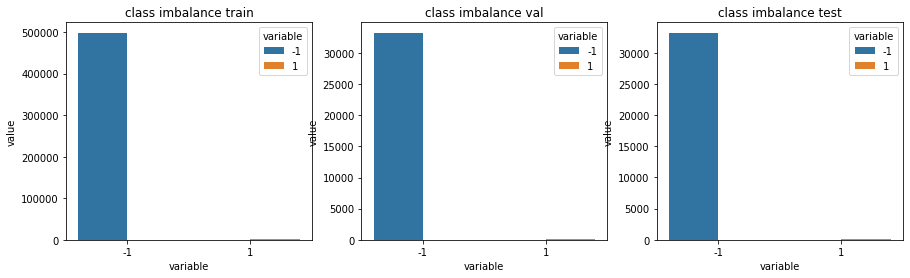

In [ ]:
fig = plt.figure(figsize=(15,4))
gs = fig.add_gridspec(1, 3)

for i, y_ in enumerate([y_train, y_val, y_test]):
  ax = fig.add_subplot(gs[i])
  plot_class_distribution(y_)
  ax.set_title("class imbalance " + ['train','val', 'test'][i])

In [ ]:
# Work with dense datasets
# X_train = np.asarray(X_train.todense())
# X_val = np.asarray(X_val.todense())
# X_test = np.asarray(X_test.todense())
# X_hidden = np.asarray(X_hidden.todense())

## Training

### Default

In [ ]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

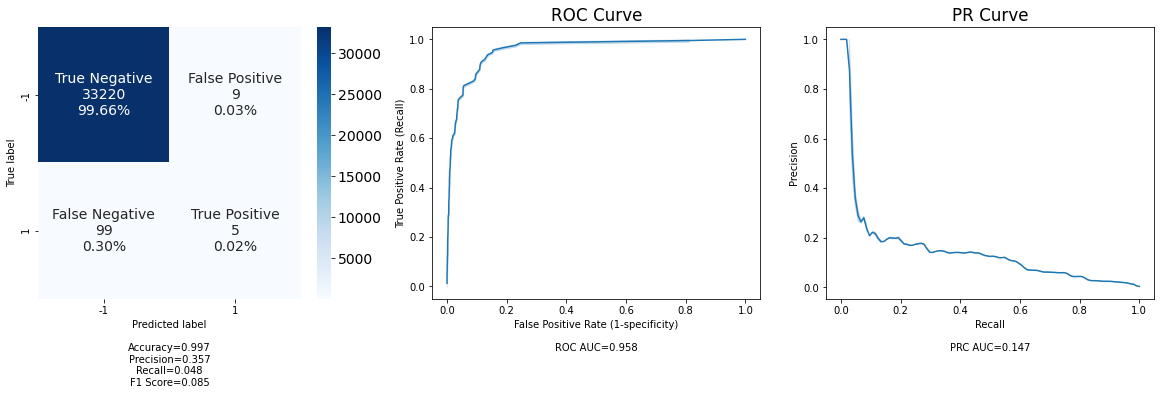

In [ ]:
_, _, res = pred_results(clf, X=X_test, y=y_test, model_name = 'default', figsize=(20,5))

### Class weights

In [ ]:
cls_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cls_weight_dict = {0: cls_weights[0], 1: cls_weights[1]}

In [ ]:
clf_cls = LogisticRegression(random_state=42, max_iter=500, class_weight=cls_weight_dict)
clf_cls.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.5014753404516087, 1: 169.9524133242692},
                   max_iter=500, random_state=42)

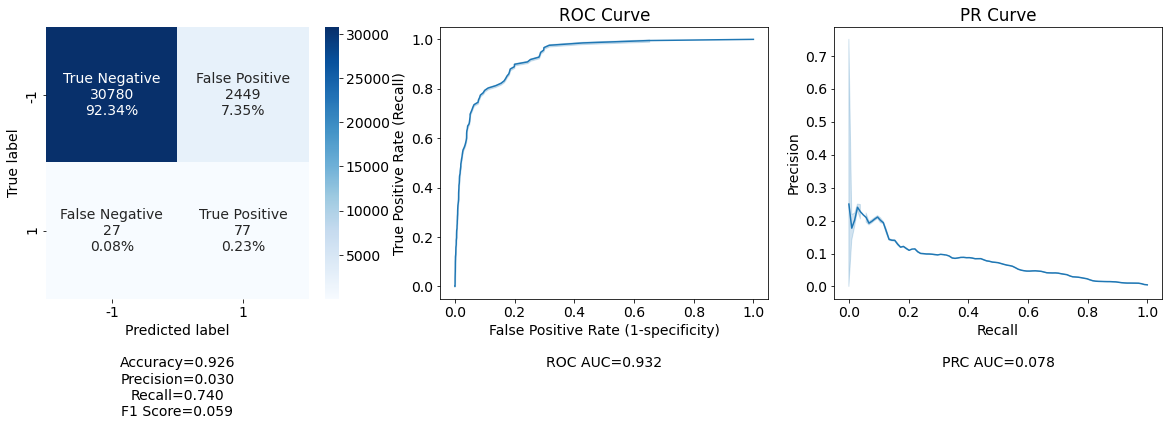

In [ ]:
_, _, res_cls = pred_results(clf=clf_cls, X=X_test, y=y_test, model_name="class_weights", figsize=(20,5))

Unexpectedly, PRC AUC is considerably lower with class weights in comparison to default setting.

### Over-/Undersample

Similar to the C. elegans dataset, we applied over- and undersampling as well as combinations thereof. However, performance was worse than the default resp. class weighted model. Thus, we will not report it here.

### Hyperparameter tuning

In [ ]:
scoring_crit = [f_classif] 
reg_C = np.logspace(-1,0,2)   
penalty_ls = ['l2'] 
k_select = list(range(25,275,25)) + [99999] # 99999 will pick full dataset
weighting = ['no_clw', 'clw']

hyperparam_human_res = pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})

for k, scoring in product(k_select, scoring_crit):

  if k >= X_train.shape[1]:
    k = X_train.shape[1]
    X_k_train = X_train
    X_k_val = X_val
  else:
    selKBest = SelectKBest(score_func=scoring, k=k)
    selKBest.fit(X_train, y_train)
    X_k_train = selKBest.transform(X_train)
    X_k_val = selKBest.transform(X_val)

  for pen, c, weight in product(penalty_ls, reg_C, weighting):

    if weight == 'no_clw':
      weight_dict = {0:1, 1:1}
    elif weight == 'clw':
      weight_dict = cls_weight_dict

    print('Currently at scoring: {}, penalty: {}, with C: {}, weighting: {} and {}-best features'.format(scoring.__name__, pen, c, weight, k))

    if pen == 'elasticnet': clf_k = LogisticRegression(penalty=pen, C=c, solver='saga', l1_ratio=0.5, random_state=42, max_iter=500, class_weight=weight_dict)
    elif pen =='l1': clf_k = LogisticRegression(penalty=pen, C=c, solver='liblinear', random_state=42, max_iter=500, class_weight=weight_dict)
    elif pen =='l2': clf_k = LogisticRegression(penalty=pen, C=c, solver='lbfgs', random_state=42, max_iter=500, class_weight=weight_dict)

    clf_k.fit(X_k_train, y_train)
    _, _, res_k = pred_results(clf=clf_k, X=X_k_val, y=y_val, model_name="pen-{}_c{}_score-{}_weight-{}_k-{}".format(pen, c, scoring.__name__,weight, k), figsize=None)

    hyperparam_human_res = pd.concat([hyperparam_human_res,res_k], axis=0).reset_index(drop=True)

In [ ]:
hyperparam_human_res['avg'] = hyperparam_human_res.mean(axis=1)
hyperparam_human_res['weighted'] = 0.15*hyperparam_human_res['f1-score'] + 0.15*hyperparam_human_res['balanced_accuracy'] + 0.35*hyperparam_human_res['roc_auc'] + 0.35*hyperparam_human_res['prc_auc'] 

Display hyperparameter tuning results and sort them according to best PRC AUC

In [ ]:
hyperparam_human_res.sort_values('prc_auc', ascending=False).iloc[:10,:]

In [ ]:
display(hyperparam_human_res.style.highlight_max(color = 'lightgreen', axis = 0))

### Select model for test set predictions


Based on best result wrt PRC AUC, we use the following parametrization for the predicition on the test set:

*   Penalty: $l_2$
*   No class weights
*   Regularization parameter $c=1.0$
*   250 k-best features according to f_classif score


In [ ]:
scoring = f_classif
k = 250
penalty = 'l2'
c = 1

selKBest = SelectKBest(score_func=f_classif, k=k)
selKBest.fit(X_train, y_train)

X_k_train = selKBest.transform(X_train)
X_k_test = selKBest.transform(X_test)
X_k_hidden = selKBest.transform(X_hidden)

clf_k = LogisticRegression(penalty=penalty, C=c, solver='lbfgs', random_state=42, max_iter=500) #, class_weight=cls_weight_dict)
clf_k.fit(X_k_train, y_train)
proba_test, pred_test, res_test = pred_results(clf=clf_k, X=X_k_test, y=y_test, model_name="pen-{}_c-{}_score-{}_k-{}_no_clw".format(penalty, c, scoring.__name__, k), figsize=None)

# replace label 0 by -1 again
pred_test[pred_test < 0.5]=-1

In [ ]:
# prediction on the hidden dataset

pred_hidden = clf_k.predict(X_k_hidden)
# replace label 0 by -1 again
pred_hidden[pred_hidden<0.5]=-1

proba_hidden = clf_k.predict_proba(X_k_hidden)

In [ ]:
results_human = pd.concat([res, res_cls, res_k], axis=0).reset_index(drop=True)
results_human['avg'] = results_human.mean(axis=1)
results_human['weighted'] = 0.15*results_human['f1-score'] + 0.15*results_human['balanced_accuracy'] + 0.35*results_human['roc_auc'] + 0.35*results_human['prc_auc'] 

In [ ]:
display(results_human.style.highlight_max(color = 'lightgreen', axis = 0))

,model,f1-score,balanced_accuracy,roc_auc,prc_auc,avg,weighted
0,default,0.996760,0.523903,0.958028,0.147482,0.656543,0.615028
1,class_weights,0.925719,0.833342,0.931672,0.078035,0.692192,0.617257
2,pen-l2_c-1_score-f_classif_k-250_no_clw,0.996760,0.514318,0.964852,0.167314,0.660811,0.622920


The tuned model has indeed the best test PRC AUC.

#### Create test predicition output for public and hidden dataset

In [ ]:
pd.DataFrame(pred_test).to_csv("./predictions/human_test_logreg_l2_c{}_sel{}_no_clw.csv".format(c,k))
pd.DataFrame(proba_test).to_csv("./predictions/proba_human_test_logreg_l2_c{}_sel{}_no_clw.csv".format(c,k))

pd.DataFrame(pred_hidden).to_csv("./predictions/human_test_hidden_logreg_l2_c{}_sel{}_no_clw.csv".format(c,k))
pd.DataFrame(proba_hidden).to_csv("./predictions/proba_human_test_hidden_logreg_l2_c{}_sel{}_no_clw.csv".format(c,k))